In [399]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

Here we will explore the eRNA annotated phenotypes. eRNA annotations come from ProCap data from [Kristjánsdóttir et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7687912/). We use the base pair locations annotated as distal enhancers and proximal enhancers. We use a 401 bp window around each annotated enhancer, and use featureCounts to count the number of reads of each RNA-seq assay that overlaps with the window. I will refer to these windows as "annotated eRNAs". We append the resulting count matrix to the gene expression and cheRNA counts matrices, and normalize to RPKM. 

In [334]:
chRNA = pd.read_csv('chRNA.RPKM.tab.gz', sep='\t', index_col=0)
polyA = pd.read_csv('polyA.RPKM.tab.gz', sep='\t', index_col=0)
ml30 = pd.read_csv('MetabolicLabelled.30min.RPKM.tab.gz', sep='\t', index_col=0)
ml60 = pd.read_csv('MetabolicLabelled.60min.RPKM.tab.gz', sep='\t', index_col=0)

chRNA_intron = pd.read_csv('chRNA.RPKM_intron.tab.gz', sep='\t', index_col=0)
polyA_intron = pd.read_csv('polyA.RPKM_intron.tab.gz', sep='\t', index_col=0)
ml30_intron = pd.read_csv('MetabolicLabelled.30min.RPKM_intron.tab.gz', sep='\t', index_col=0)
ml60_intron = pd.read_csv('MetabolicLabelled.60min.RPKM_intron.tab.gz', sep='\t', index_col=0)

ProCap_eRNA = pd.read_csv('ProCap.RPKM_eRNA.tab.gz', sep='\t', index_col=0)
chRNA_eRNA = pd.read_csv('chRNA.RPKM_eRNA.tab.gz', sep='\t', index_col=0)
polyA_eRNA = pd.read_csv('polyA.RPKM_eRNA.tab.gz', sep='\t', index_col=0)
ml30_eRNA = pd.read_csv('MetabolicLabelled.30min.RPKM_eRNA.tab.gz', sep='\t', index_col=0)
ml60_eRNA = pd.read_csv('MetabolicLabelled.60min.RPKM_eRNA.tab.gz', sep='\t', index_col=0)

eRNA = pd.read_csv('eRNA.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])
eRNA_exon = pd.read_csv('eRNA.Exons.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])
eRNA_intron = pd.read_csv('eRNA.Introns.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])


eRNA_intron_ac = pd.read_csv('eRNA.Introns.h3k27ac.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])
eRNA_intron_ = pd.read_csv('eRNA.Introns.no_h3k27ac.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])

eRNA_exon_ac = pd.read_csv('eRNA.Exons.h3k27ac.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])
eRNA_exon_ = pd.read_csv('eRNA.Exons.no_h3k27ac.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])

eRNA_noGene = pd.read_csv('eRNA.noGenes.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])
eRNA_noGene_ac = pd.read_csv('eRNA.noGenes.h3k27ac.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])
eRNA_noGene_ = pd.read_csv('eRNA.noGenes.no_h3k27ac.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])


eRNA_geneOverlap = pd.read_csv('eRNA.Exons.GeneOverlap.bed', sep='\t',  
        names = ['chrom', 'start', 'end', 'enhancer', 'chromGene', 'startGene', 
                 'endGene', 'gene', 'score', 'strand', 'overlap'])

eRNA_intronOverlap = pd.read_csv('eRNA.Introns.Overlap.bed', sep='\t', 
        names = ['chrom', 'start', 'end', 'enhancer', 'chromGene', 'startGene', 
                 'exonGene', 'intron', 'gene'])

eRNA_ac = pd.read_csv('eRNA.h3k27ac.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])
eRNA_me = pd.read_csv('eRNA.h3k4me3.bed', sep='\t', index_col=3, names = ['chrom', 'start', 'end'])

# eRNA annotation

First we will check for overlap between the annotated eRNAs, and histone marks that usually mark enhancers (H3K27ac, and H3K4me3). I used bedtools intersect to check for overlaps. I required at leas 90% of the annotated eRNA sequence to overlap with a peak. I also classified the annotated eRNAs on whether they overlap with an exon (protein coding or otherwise), an intron, or if they don't overlap with any gene.

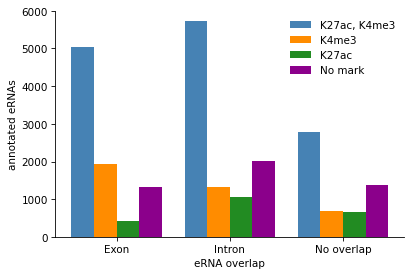

In [426]:
x = np.arange(3)
y1 = [len(eRNA_exon.index.intersection(eRNA_ac.index).intersection(eRNA_me.index)), 
      len(eRNA_intron.index.intersection(eRNA_ac.index).intersection(eRNA_me.index)),
      len(eRNA_noGene.index.intersection(eRNA_ac.index).intersection(eRNA_me.index))
     ]
y2 = [len(eRNA_exon.index.difference(eRNA_ac.index).intersection(eRNA_me.index)), 
      len(eRNA_intron.index.difference(eRNA_ac.index).intersection(eRNA_me.index)),
      len(eRNA_noGene.index.difference(eRNA_ac.index).intersection(eRNA_me.index))
     ]
y3 = [len(eRNA_exon.index.intersection(eRNA_ac.index).difference(eRNA_me.index)), 
      len(eRNA_intron.index.intersection(eRNA_ac.index).difference(eRNA_me.index)),
      len(eRNA_noGene.index.intersection(eRNA_ac.index).difference(eRNA_me.index))
     ]
y4 = [len(eRNA_exon.index.difference(eRNA_ac.index).difference(eRNA_me.index)), 
      len(eRNA_intron.index.difference(eRNA_ac.index).difference(eRNA_me.index)),
      len(eRNA_noGene.index.difference(eRNA_ac.index).difference(eRNA_me.index))
     ]
width = 0.2
  
fig, ax = plt.subplots(dpi=75)
ax.bar(x-0.3, y1, width, color='steelblue')
ax.bar(x-0.1, y2, width, color='darkorange')
ax.bar(x+0.1, y3, width, color='forestgreen')
ax.bar(x+0.3, y4, width, color='darkmagenta')

ax.set_xticks(x)
ax.set_xticklabels(['Exon', 'Intron', 'No overlap'])
ax.set_xlabel("eRNA overlap")
ax.set_ylabel("annotated eRNAs")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(["K27ac, K4me3", "K4me3", "K27ac", "No mark"], frameon=False)
plt.show()

Unsurprisingly, most annotated eRNAs overlap with both histone marks. It seems that there aren't that many that overlap with one mark but not the other, which seems reasonable. We can also see that the majority of the eRNAs overlap with an exon or an intron, with only a minority falling outside of a gene.

Next, let's check the expression of eRNAs, depending on their annotation.

# eRNA expression in the different assays

Text(410.0, 2, 'polyA')

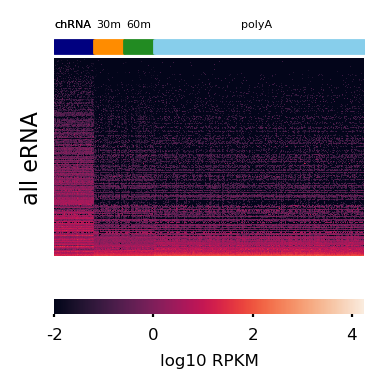

In [427]:
chRNA_cols = ['chRNA_' + x for x in chRNA_eRNA.columns]
chRNA_eRNA.columns = chRNA_cols

ml30_cols = ['ml30_' + x for x in ml30_eRNA.columns]
ml30_eRNA.columns = ml30_cols

ml60_cols = ['ml60_' + x for x in ml60_eRNA.columns]
ml60_eRNA.columns = ml60_cols

polyA_cols = ['polyA_' + x for x in polyA_eRNA.columns]
polyA_eRNA.columns = polyA_cols


df = pd.concat([chRNA_eRNA, ml30_eRNA, ml60_eRNA, polyA_eRNA], axis=1).clip(lower=0.01)
expressed_eRNA = df.mean(axis=1).sort_values().index

fig, (ax0, ax1) = plt.subplots(figsize = (2,2), nrows=2, dpi=200, gridspec_kw={'height_ratios': [1, 20]})
fig.subplots_adjust(hspace=0.03)

hm = sns.heatmap(np.log10(df.loc[expressed_eRNA]), 
            cbar_kws = dict(use_gridspec=False,location="bottom", label='log10 RPKM'), ax=ax1)



ax0.set_yticks([])
ax1.set_yticks([])

ax0.set_xticks([])
ax1.set_xticks([])

ax1.set_ylabel('all eRNA', size=8)

hm.figure.axes[-1].xaxis.label.set_size(6)
hm.figure.axes[-1].xaxis.set_ticks([-2, 0, 2, 4])
hm.figure.axes[-1].xaxis.set_tick_params(size=1)
hm.figure.axes[-1].xaxis.set_ticklabels(['-2', '0', '2', '4'], size=6)

ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)


s1 = len(chRNA_eRNA.columns)
s2 = len(ml30_eRNA.columns) + s1
s3 = len(ml60_eRNA.columns) + s2
s4 = len(polyA_eRNA.columns) + s3
# s5 = len(ProCap_RPKM.columns) + s4

ax0.fill_between([0, s1], [0, 0], [1, 1], color='navy')
ax0.fill_between([s1, s2], [0, 0], [1, 1], color='darkorange')
ax0.fill_between([s2, s3], [0, 0], [1, 1], color='forestgreen')
ax0.fill_between([s3, s4], [0, 0], [1, 1], color='skyblue')
# ax0.fill_between([s4, s5], [0, 0], [1, 1], color='red')

ax0.set_xlim([0, s4])
ax0.text(0, 2, 'chRNA', size=4)

ax0.set_xlim([0, s4])
ax0.text(0, 2, 'chRNA', size=4)
ax0.text(s1+5, 2, '30m', size=4)
ax0.text(s2+5, 2, '60m', size=4)
ax0.text(np.mean([s3, s4])-40, 2, 'polyA', size=4)

### eRNAs overlapping exons

Text(410.0, 2, 'polyA')

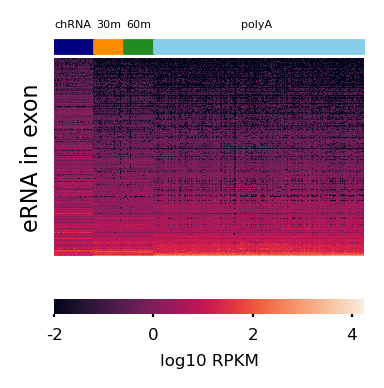

In [320]:
fig, (ax0, ax1) = plt.subplots(figsize = (2,2), nrows=2, dpi=200, gridspec_kw={'height_ratios': [1, 20]})
fig.subplots_adjust(hspace=0.03)

expressed_eRNA = df.loc[eRNA_exon.index].mean(axis=1).sort_values().index
expressed_eRNA = chRNA_eRNA.loc[expressed_eRNA].loc[(chRNA_eRNA.loc[expressed_eRNA].mean(axis=1) > 0.1)].index
hm = sns.heatmap(np.log10(df.loc[expressed_eRNA]), 
            cbar_kws = dict(use_gridspec=False,location="bottom", label='log10 RPKM'), ax=ax1)



ax0.set_yticks([])
ax1.set_yticks([])

ax0.set_xticks([])
ax1.set_xticks([])

ax1.set_ylabel('eRNA in exon', size=8)

hm.figure.axes[-1].xaxis.label.set_size(6)
hm.figure.axes[-1].xaxis.set_ticks([-2, 0, 2, 4])
hm.figure.axes[-1].xaxis.set_tick_params(size=1)
hm.figure.axes[-1].xaxis.set_ticklabels(['-2', '0', '2', '4'], size=6)

ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)


s1 = len(chRNA_eRNA.columns)
s2 = len(ml30_eRNA.columns) + s1
s3 = len(ml60_eRNA.columns) + s2
s4 = len(polyA_eRNA.columns) + s3
# s5 = len(ProCap_RPKM.columns) + s4

ax0.fill_between([0, s1], [0, 0], [1, 1], color='navy')
ax0.fill_between([s1, s2], [0, 0], [1, 1], color='darkorange')
ax0.fill_between([s2, s3], [0, 0], [1, 1], color='forestgreen')
ax0.fill_between([s3, s4], [0, 0], [1, 1], color='skyblue')
# ax0.fill_between([s4, s5], [0, 0], [1, 1], color='red')

ax0.set_xlim([0, s4])
ax0.text(0, 2, 'chRNA', size=4)
ax0.text(s1+5, 2, '30m', size=4)
ax0.text(s2+5, 2, '60m', size=4)
ax0.text(np.mean([s3, s4])-40, 2, 'polyA', size=4)

It doesn't seem to be a big difference in expression between the different RNA-seq assays, which is pretty much what I expected. I tried to untangle eRNA from exon expression by subtracting the gene expression RPKM from the eRNA RPKM. I'm not showing plots for that, but some annotated eRNAs had much higher RPKM than the gene they overlapped. 

This is likely mere artifacts, of the RPKM calculation though. As we can see, even these eRNAs are basically impossible to tell apart from the genes.


<img src="eRNA_igv/Top_exon_enhancer_in_chRNA.PNG" alt="drawing" width="500"/>

This is particularly the case in polyA data. Some eRNAs had orders of magnitude higher RPKM than their host genes. But a quick look at them shows that this is probably garbage.

<img src="eRNA_igv/Top_exon_enhancer_in_polyA.PNG" alt="drawing" width="500"/>


### eRNAs overlapping introns

Text(410.0, 2, 'polyA')

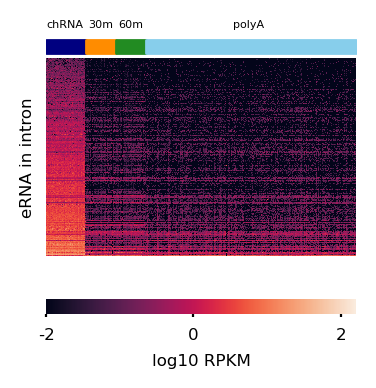

In [327]:
fig, (ax0, ax1) = plt.subplots(figsize = (2,2), nrows=2, dpi=200, gridspec_kw={'height_ratios': [1, 20]})
fig.subplots_adjust(hspace=0.03)

expressed_eRNA = df.loc[eRNA_intron_ac.index].mean(axis=1).sort_values().index
expressed_eRNA = chRNA_eRNA.loc[expressed_eRNA].loc[(chRNA_eRNA.loc[expressed_eRNA].mean(axis=1) > 0.1)].index
hm = sns.heatmap(np.log10(df.loc[expressed_eRNA]), 
            cbar_kws = dict(use_gridspec=False,location="bottom", label='log10 RPKM'), ax=ax1)



ax0.set_yticks([])
ax1.set_yticks([])

ax0.set_xticks([])
ax1.set_xticks([])

ax1.set_ylabel('eRNA in intron', size=6)

hm.figure.axes[-1].xaxis.label.set_size(6)
hm.figure.axes[-1].xaxis.set_ticks([-2, 0, 2])
hm.figure.axes[-1].xaxis.set_tick_params(size=1)
hm.figure.axes[-1].xaxis.set_ticklabels(['-2', '0', '2'], size=6)

ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)


s1 = len(chRNA_eRNA.columns)
s2 = len(ml30_eRNA.columns) + s1
s3 = len(ml60_eRNA.columns) + s2
s4 = len(polyA_eRNA.columns) + s3
# s5 = len(ProCap_RPKM.columns) + s4

ax0.fill_between([0, s1], [0, 0], [1, 1], color='navy')
ax0.fill_between([s1, s2], [0, 0], [1, 1], color='darkorange')
ax0.fill_between([s2, s3], [0, 0], [1, 1], color='forestgreen')
ax0.fill_between([s3, s4], [0, 0], [1, 1], color='skyblue')
# ax0.fill_between([s4, s5], [0, 0], [1, 1], color='red')

ax0.set_xlim([0, s4])
ax0.text(0, 2, 'chRNA', size=4)
ax0.text(s1+5, 2, '30m', size=4)
ax0.text(s2+5, 2, '60m', size=4)
ax0.text(np.mean([s3, s4])-40, 2, 'polyA', size=4)

There's a lot more expression in chRNA-seq, than in other assays. However, how much of that is really from eRNAs, and how much is it because we observe more intronic counts in chRNA-seq?

Not shown, but I tried to untangle this by adding intronic counts to the RPKM calculation, this by subtracting the intronic RPKM from the eRNA RPKM. Surprisingly, none of the eRNAs had a higher RPKM on average across samples, than the corresponding intron, I'm not really sure why. featureCounts doesn't assign reads that map to overlapping features, so I don't think that passing everything together to featureCounts would solve that. 

Anyways... still, the eRNAs with highest RPKM - intron RPKM (although negative) look like they could be legit eRNAs.

<img src="eRNA_igv/Top_intron_enhancer_in_chRNA.PNG" alt="drawing" width="500"/>
<img src="eRNA_igv/Top_Second_Intron_enhancer_in_chRNA.PNG" alt="drawing" width="500"/>

However, others don't look as reliable (in the first of the two next plots, dark blue is chRNA and orange is polyA)
<img src="eRNA_igv/enhancers_overlapping_gene.PNG" alt="drawing" width="500"/>
<img src="eRNA_igv/Top_intron_enhancer_in_polyA.PNG" alt="drawing" width="500"/>

### eRNAs overlapping histone marks peaks, but not genes

Text(410.0, 2, 'polyA')

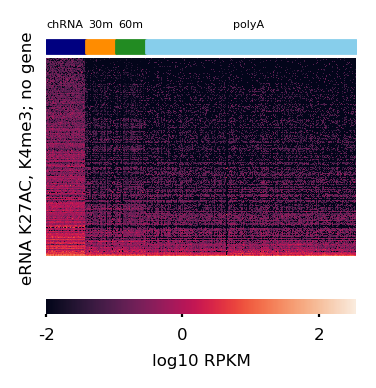

In [330]:
fig, (ax0, ax1) = plt.subplots(figsize = (2,2), nrows=2, dpi=200, gridspec_kw={'height_ratios': [1, 20]})
fig.subplots_adjust(hspace=0.03)

expressed_eRNA = df.loc[eRNA_noGene.index.intersection(eRNA_ac.index).intersection(eRNA_me.index)].mean(axis=1).sort_values().index
expressed_eRNA = chRNA_eRNA.loc[expressed_eRNA].loc[(chRNA_eRNA.loc[expressed_eRNA].mean(axis=1) > 0.1)].index
hm = sns.heatmap(np.log10(df.loc[expressed_eRNA]), 
            cbar_kws = dict(use_gridspec=False,location="bottom", label='log10 RPKM'), ax=ax1)



ax0.set_yticks([])
ax1.set_yticks([])

ax0.set_xticks([])
ax1.set_xticks([])

ax1.set_ylabel('eRNA K27AC, K4me3; no gene', size=6)

hm.figure.axes[-1].xaxis.label.set_size(6)
hm.figure.axes[-1].xaxis.set_ticks([-2, 0, 2])
hm.figure.axes[-1].xaxis.set_tick_params(size=1)
hm.figure.axes[-1].xaxis.set_ticklabels(['-2', '0', '2'], size=6)

ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)


s1 = len(chRNA_eRNA.columns)
s2 = len(ml30_eRNA.columns) + s1
s3 = len(ml60_eRNA.columns) + s2
s4 = len(polyA_eRNA.columns) + s3
# s5 = len(ProCap_RPKM.columns) + s4

ax0.fill_between([0, s1], [0, 0], [1, 1], color='navy')
ax0.fill_between([s1, s2], [0, 0], [1, 1], color='darkorange')
ax0.fill_between([s2, s3], [0, 0], [1, 1], color='forestgreen')
ax0.fill_between([s3, s4], [0, 0], [1, 1], color='skyblue')
# ax0.fill_between([s4, s5], [0, 0], [1, 1], color='red')

ax0.set_xlim([0, s4])
ax0.text(0, 2, 'chRNA', size=4)
ax0.text(s1+5, 2, '30m', size=4)
ax0.text(s2+5, 2, '60m', size=4)
ax0.text(np.mean([s3, s4])-40, 2, 'polyA', size=4)



These might be more legit eRNAs, at least from how they look. Worth noting though that the first one seems to be close to what looks like an unannotated gene. The second looks like part of a very large transcribed region, full of histone mark peaks. 

<img src="eRNA_igv/Top_noGene_enhancer_in_chRNA.PNG" alt="drawing" width="500"/>
<img src="eRNA_igv/Top_Second_noGene_enhancer_in_chRNA.PNG" alt="drawing" width="500"/>



### eRNAs overlapping neither histone marks, nor genes

Text(410.0, 2, 'polyA')

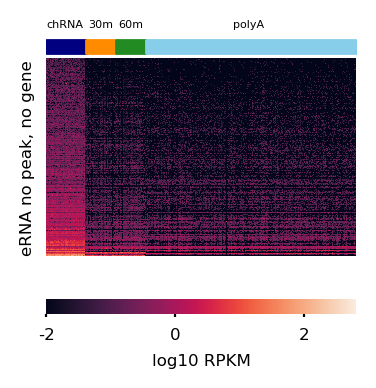

In [332]:
fig, (ax0, ax1) = plt.subplots(figsize = (2,2), nrows=2, dpi=200, gridspec_kw={'height_ratios': [1, 20]})
fig.subplots_adjust(hspace=0.03)

expressed_eRNA = df.loc[eRNA_noGene.index.difference(eRNA_ac.index).difference(eRNA_me.index)].mean(axis=1).sort_values().index
expressed_eRNA = chRNA_eRNA.loc[expressed_eRNA].loc[(chRNA_eRNA.loc[expressed_eRNA].mean(axis=1) > 0.1)].index
hm = sns.heatmap(np.log10(df.loc[expressed_eRNA]), 
            cbar_kws = dict(use_gridspec=False,location="bottom", label='log10 RPKM'), ax=ax1)



ax0.set_yticks([])
ax1.set_yticks([])

ax0.set_xticks([])
ax1.set_xticks([])

ax1.set_ylabel('eRNA no peak, no gene', size=6)

hm.figure.axes[-1].xaxis.label.set_size(6)
hm.figure.axes[-1].xaxis.set_ticks([-2, 0, 2])
hm.figure.axes[-1].xaxis.set_tick_params(size=1)
hm.figure.axes[-1].xaxis.set_ticklabels(['-2', '0', '2'], size=6)

ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)


s1 = len(chRNA_eRNA.columns)
s2 = len(ml30_eRNA.columns) + s1
s3 = len(ml60_eRNA.columns) + s2
s4 = len(polyA_eRNA.columns) + s3
# s5 = len(ProCap_RPKM.columns) + s4

ax0.fill_between([0, s1], [0, 0], [1, 1], color='navy')
ax0.fill_between([s1, s2], [0, 0], [1, 1], color='darkorange')
ax0.fill_between([s2, s3], [0, 0], [1, 1], color='forestgreen')
ax0.fill_between([s3, s4], [0, 0], [1, 1], color='skyblue')
# ax0.fill_between([s4, s5], [0, 0], [1, 1], color='red')

ax0.set_xlim([0, s4])
ax0.text(0, 2, 'chRNA', size=4)
ax0.text(s1+5, 2, '30m', size=4)
ax0.text(s2+5, 2, '60m', size=4)
ax0.text(np.mean([s3, s4])-40, 2, 'polyA', size=4)



# eRNAs overlapping histone marks

H3K27ac and H3K4me3 histone modifications are common in enhancer regions. We expect active enhancers that transcribe eRNAs, to be more likely to fall in regions overlapping these peaks, than not. Here we take a look at the expression of eRNAs in regions overlapping these peaks, vs regions that don't overlap. We expect higher eRNA expression in regions that overlap the peaks.

In [343]:
idx_peaks = eRNA_ac.index.intersection(eRNA_me.index)
idx_no_peaks = eRNA.index.difference(eRNA_me.index).difference(eRNA_ac.index)
exon = eRNA_exon.index
intron = eRNA_intron.index
noGene = eRNA_noGene.index

In [354]:
def make_expression_df(df, idx_peaks, idx_no_peaks, exon, intron, noGene):
    
    df_expression = pd.DataFrame()
    
    peaks_expression = np.log10(df.clip(lower=10e-3).loc[idx_peaks]).mean(axis=1)
    no_peaks_expression = np.log10(df.clip(lower=10e-3).loc[idx_no_peaks]).mean(axis=1)
    
    peaks_expression_exon = list(peaks_expression.loc[idx_peaks.intersection(exon)])
    peaks_expression_intron = list(peaks_expression.loc[idx_peaks.intersection(intron)])
    peaks_expression_noGene = list(peaks_expression.loc[idx_peaks.intersection(noGene)])
    
    no_peaks_expression_exon = list(no_peaks_expression.loc[idx_no_peaks.intersection(exon)])
    no_peaks_expression_intron = list(no_peaks_expression.loc[idx_no_peaks.intersection(intron)])
    no_peaks_expression_noGene = list(no_peaks_expression.loc[idx_no_peaks.intersection(noGene)])
    
    peaks_label = ['K27ac, K4me3']*len(peaks_expression_exon + peaks_expression_intron + peaks_expression_noGene)
    peaks_label += ['no peaks']*len(no_peaks_expression_exon + no_peaks_expression_intron + no_peaks_expression_noGene)
    annotation = (['exon']*len(peaks_expression_exon)) + (['intron']*len(peaks_expression_intron))
    annotation += (['no gene']*len(peaks_expression_noGene)) + (['exon']*len(no_peaks_expression_exon))
    annotation += (['intron']*len(no_peaks_expression_intron)) + (['no gene']*len(no_peaks_expression_noGene))
    
    RPKM = peaks_expression_exon + peaks_expression_intron + peaks_expression_noGene
    RPKM += no_peaks_expression_exon + no_peaks_expression_intron + no_peaks_expression_noGene
    df_expression['RPKM'] = RPKM
    df_expression['peaks'] = peaks_label
    df_expression['annotation'] = annotation
    return df_expression

In [374]:
def plot_expression_by_annotation(df, name, idx_peaks, idx_no_peaks, exon, intron, noGene):
 
    avg_rpkm = make_expression_df(df, idx_peaks, idx_no_peaks, exon, intron, noGene)

    fig, ax = plt.subplots(dpi=75)

    ax = sns.boxplot(x="annotation", y="RPKM", hue="peaks",
                     data=avg_rpkm, palette="Set3")
    ax.legend(frameon=False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(name + ' eRNA expression')
    plt.show()

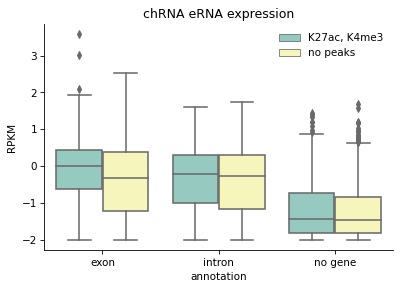

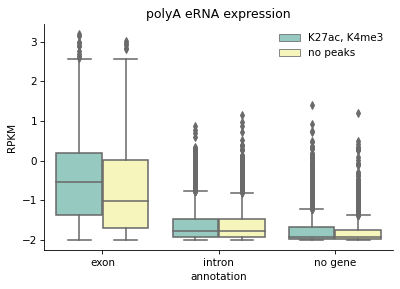

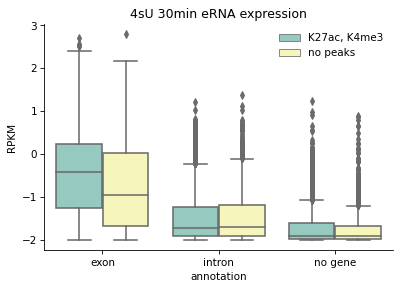

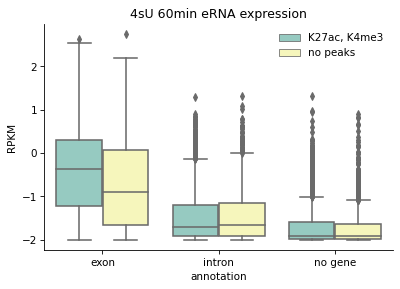

In [392]:
plot_expression_by_annotation(chRNA_eRNA, 'chRNA', idx_peaks, idx_no_peaks, exon, intron, noGene)
plot_expression_by_annotation(polyA_eRNA, 'polyA', idx_peaks, idx_no_peaks, exon, intron, noGene)
plot_expression_by_annotation(ml30_eRNA, '4sU 30min', idx_peaks, idx_no_peaks, exon, intron, noGene)
plot_expression_by_annotation(ml60_eRNA, '4sU 60min', idx_peaks, idx_no_peaks, exon, intron, noGene)

The results don't seem very definitive. All assays show higher expression in enhancers overlapping exons if they also overlap with peaks, than if they don't overlap with peaks. But this is likely because these marks are associated with higher gene expression. As we can see, this difference is even present in polyA RNA-seq, where we don't expect to capture eRNA. 

As expected, we see more intron expression in chRNA-seq, than in other assays. But how much is this from enhancer activity. If we squint out eyes, maybe we can see that intron eRNAs that overlap peaks are more expressed than those that don't. But again, this could be an artifact of gene expression.

Finally there are also slight increase in expression in enhancers that don't overlap any part of a gene. This is more likely to be a legitimate result. However, I'm concerned that the difference doesn't seem to be that clear. 

# ProCap data seems better for analysing eRNAs

Now let's take a look at the original ProCap data to see if we can get any new insights. There are some unfortunate problems with the annotation names (which is something that I'll correct later). So let's fix that first.

In [ ]:
procap = pd.read_csv('../../ProCapAnalysis/ProCap.CountTable.hg38.bed', sep='\t').groupby('pid').sum()
prosamples = procap.columns[2:]
samples_procap = ['NA' + x[2:] for x in prosamples]
procap = procap[prosamples].copy()
procap.columns = samples_procap

procap_features = pd.read_csv('../../ProCapAnalysis/CountTable.hg38.features.bed', sep='\t',
                             names = ['chrom', 'start', 'end', 'id', 'enhancer', 'strand'])

procap_features['enhancer_id'] = procap_features[['enhancer', 'id']].agg('_'.join, axis=1)
procap_features['new_id'] = procap_features[['enhancer', 'chrom', 'start']].astype(str).agg('_'.join, axis=1)
procap_features = procap_features.groupby('new_id').first()
# procap_features = procap_features.set_index('new_id')

new_idx = procap_features.drop_duplicates().index.intersection(procap.drop_duplicates().index)
procap = procap.loc[new_idx].copy()
procap.index = procap_features.loc[new_idx].enhancer_id

Now that that is corrected, let's look at the expression in the different eRNAs.

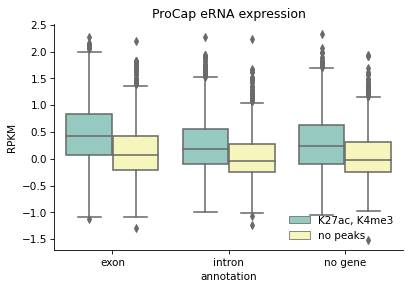

In [393]:
plot_expression_by_annotation(procap, 'ProCap', idx_peaks.intersection(procap.index), idx_no_peaks, exon, intron, noGene)

This actually looks pretty good. There are some differences in eRNAs overlapping exons vs introns vs no gene, but they are very small compared with the other assays. The clear difference, however, comes on whether the eRNAs overlap with histone marks or not. This is exactly what we expected, and it makes me believe that this is capturing legitimate eRNA expression.

# ProCap data is correlated with chRNA data

Finally, let's see if eRNA expression in ProCap is correlated with expression in chRNA.

Text(0.5, 1.0, 'all eRNA')

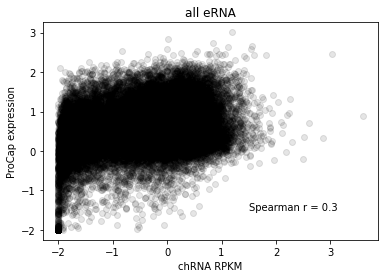

In [412]:
plt.scatter(
np.log10(chRNA_eRNA.loc[ProCap_eRNA.index].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[ProCap_eRNA.index].clip(lower=0.01)).mean(axis=1),
    alpha=0.1, c='black'
)
plt.xlabel('chRNA RPKM')
plt.ylabel('ProCap expression')

spearman = spearmanr(np.log10(chRNA_eRNA.loc[ProCap_eRNA.index].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[ProCap_eRNA.index].clip(lower=0.01)).mean(axis=1))[0]

plt.text(1.5, -1.5, 'Spearman r = ' + str(round(spearman, 2)))
plt.title('all eRNA')

Text(0.5, 1.0, 'all eRNA in peaks')

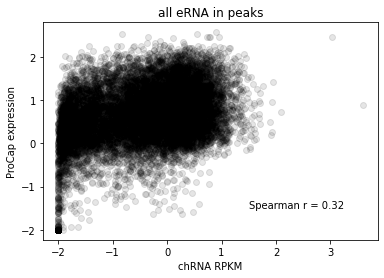

In [414]:
plt.scatter(
np.log10(chRNA_eRNA.loc[ProCap_eRNA.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[ProCap_eRNA.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1),
    alpha=0.1, c='black'
)
plt.xlabel('chRNA RPKM')
plt.ylabel('ProCap expression')

spearman = spearmanr(np.log10(chRNA_eRNA.loc[ProCap_eRNA.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[ProCap_eRNA.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1))[0]

plt.text(1.5, -1.5, 'Spearman r = ' + str(round(spearman, 2)))
plt.title('all eRNA in peaks')

Text(0.5, 1.0, 'eRNA no Genes')

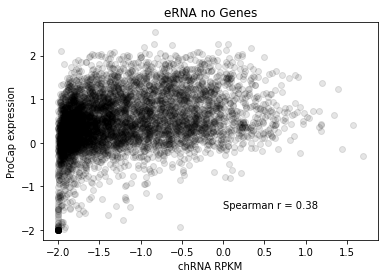

In [413]:
plt.scatter(
np.log10(chRNA_eRNA.loc[eRNA_noGene.index].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[eRNA_noGene.index].clip(lower=0.01)).mean(axis=1),
    alpha=0.1, c='black'
)
plt.xlabel('chRNA RPKM')
plt.ylabel('ProCap expression')

spearman = spearmanr(np.log10(chRNA_eRNA.loc[eRNA_noGene.index].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[eRNA_noGene.index].clip(lower=0.01)).mean(axis=1))[0]

plt.text(0, -1.5, 'Spearman r = ' + str(round(spearman, 2)))
plt.title('eRNA no Genes')

Text(0.5, 1.0, 'eRNA no Genes in peaks')

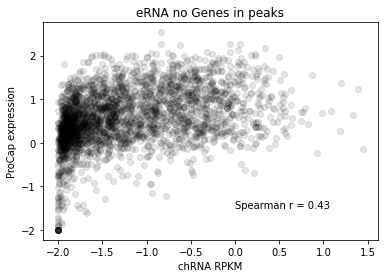

In [415]:
plt.scatter(
np.log10(chRNA_eRNA.loc[eRNA_noGene.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[eRNA_noGene.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1),
    alpha=0.1, c='black'
)
plt.xlabel('chRNA RPKM')
plt.ylabel('ProCap expression')

spearman = spearmanr(np.log10(chRNA_eRNA.loc[eRNA_noGene.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1),
    np.log10(ProCap_eRNA.loc[eRNA_noGene.index.intersection(idx_peaks)].clip(lower=0.01)).mean(axis=1))[0]

plt.text(0, -1.5, 'Spearman r = ' + str(round(spearman, 2)))
plt.title('eRNA no Genes in peaks')

The correlation is modest when looking at all annotated eRNAs. It improves if we look at eRNAs overlapping histone marks. It further improces if looking at eRNAs not overlapping with genes.

# Discussion

These results indicate that chRNA is probably capturing legitimate eRNAs. However, there are a lot of confounders that make me question how reliable is the signal that we are getting. Specially when the eRNAs overlap any part of the gene body (exon or intron). In annotated enhancers that don't overlap with any gene, the effect of overlapping with histone marks is not as clear. 

Therefore I suggest the following: 
* Ignore enhancers overlapping exons. Getting any legitimate signal from them looks very difficult.
* Work only with enhancers not overlapping any genes. I'm open to be convinced to work with enhancers overapping introns.
* Get QTLs from eRNAs not overlapping genes, and compare with QTLs that we get from ProCap. 
* For the sake of the biological questions, including coloc and GWAS, let's work with ProCap data.

The idea is to show that eRNAs are something that you can explore if you have chRNA data. We could use ProCap as a gold standard, and compare the eRNA QTLs in chRNA (e.g., with colocalization, correlation of betas, etc). But for GWAS, and other biological qustions, we probably should use ProCap.

Text(486.0, 2, 'polyA')

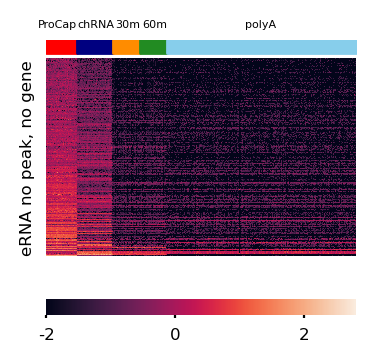

In [425]:
fig, (ax0, ax1) = plt.subplots(figsize = (2,2), nrows=2, dpi=200, gridspec_kw={'height_ratios': [1, 20]})
fig.subplots_adjust(hspace=0.03)

df = pd.concat([procap, chRNA_eRNA, ml30_eRNA, ml60_eRNA, polyA_eRNA], axis=1).clip(lower=0.01)

expressed_eRNA = df.loc[eRNA_noGene.index.difference(eRNA_ac.index).difference(eRNA_me.index)].mean(axis=1).sort_values().index
expressed_eRNA = chRNA_eRNA.loc[expressed_eRNA].loc[(chRNA_eRNA.loc[expressed_eRNA].mean(axis=1) > 0.1)].index
hm = sns.heatmap(np.log10(df.loc[expressed_eRNA]), cbar_kws = dict(use_gridspec=False,location="bottom"), ax=ax1)
# sns.heatmap(np.log10(df.loc[expressed_eRNA]), cbar_kws = dict(use_gridspec=False,location="bottom"), ax=ax1)


ax0.set_yticks([])
ax1.set_yticks([])

ax0.set_xticks([])
ax1.set_xticks([])

ax1.set_ylabel('eRNA no peak, no gene', size=6)

hm.figure.axes[-1].xaxis.label.set_size(6)
hm.figure.axes[-1].xaxis.set_ticks([-2, 0, 2])
hm.figure.axes[-1].xaxis.set_tick_params(size=1)
hm.figure.axes[-1].xaxis.set_ticklabels(['-2', '0', '2'], size=6)

ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)


s0 = len(procap.columns)
s1 = len(chRNA_eRNA.columns) + s0
s2 = len(ml30_eRNA.columns) + s1
s3 = len(ml60_eRNA.columns) + s2
s4 = len(polyA_eRNA.columns) + s3
# s5 = len(ProCap_RPKM.columns) + s4

ax0.fill_between([0, s0], [0, 0], [1, 1], color='red')
ax0.fill_between([s0, s1], [0, 0], [1, 1], color='navy')
ax0.fill_between([s1, s2], [0, 0], [1, 1], color='darkorange')
ax0.fill_between([s2, s3], [0, 0], [1, 1], color='forestgreen')
ax0.fill_between([s3, s4], [0, 0], [1, 1], color='skyblue')
# ax0.fill_between([s4, s5], [0, 0], [1, 1], color='red')

ax0.set_xlim([0, s4])


ax0.set_xlim([0, s4])
ax0.text(-20, 2, 'ProCap', size=4)
ax0.text(s0, 2, 'chRNA', size=4)
ax0.text(s1+5, 2, '30m', size=4)
ax0.text(s2+5, 2, '60m', size=4)
ax0.text(np.mean([s3, s4])-40, 2, 'polyA', size=4)

